# Overview 

So the main purpose of this study is to build the Machine Learning (ML) model that will come up with most accurate forecast for every store in every department based on given dateset. Before coming to the ML stage, traditionally we will examine the data by going through the descriptive analysis and feature engineering as well.

There are two main models that will be concidered for making the predictions which are Random Forest and Recurrent Neural Network.

# Descriptive Analysis

First we will load all available datasets that we have and initial step libraries.

In [ ]:
pip install pmdarima

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 20)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [ ]:
train = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/train.csv.zip")
features = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
sample = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')
stores  = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')

In [ ]:
print(test.Date.nunique())

Lets see what we have in the train set.

In [ ]:
train.info()

Train set is quite clean in terms of null values, which is great. Lets see what we have in 'features' set.

In [ ]:
features.info()

In [ ]:
stores.info()

In 'features' the picture is a bit different as most of features contain null values. We could consider the way of filling null values for specific features, however before, we will examine how these would be crucial in terms of future predictions. 

So next we will work a bit on feature engineering by creating the 'date dummy' fields, which will help us to explore are there any patterns for variety of 'date' type features, such as year, month, week number and etc. At the same time we will merge our test, features and stores sets for making data explorations just more handy. 

In [ ]:
## Creating calendar function
def cal (start, end):
    df_cal= pd.DataFrame({"date": pd.date_range(start, end)})
    df_cal["year"] = df_cal.date.dt.year
    df_cal["month"]= df_cal.date.dt.month
    df_cal['year_month'] = pd.to_datetime(df_cal['date']).dt.to_period('M')
    df_cal["week_num"]= df_cal.date.dt.week
    #df_cal["week_day"]= df_cal.date.dt.weekday
    #df_cal["week_day_name"]= df_cal.date.dt.weekday_name
    #df_cal["day_of_year"]= df_cal.date.dt.dayofyear
    #df_cal['date'] = df_cal['date'].dt.strftime('%Y-%m-%d')
    return df_cal

In [ ]:
pd.to_datetime(train.Date[0], format = '%Y-%m-%d').strftime('%A')

In [ ]:
# Assigning frequency 
train.Date = pd.to_datetime(train.Date, format = '%Y-%m-%d')
train.Date.freq = 'W-FRI'

In [ ]:
# Genearint calandar by use of calender function with start and end date
# of our train set
train_d = train.Date.unique()
train_d.sort(axis = 0)
train_cal = cal(train_d[0], train_d[-1])

# merge calendar to train set
train_d = pd.merge(train, train_cal, left_on = 'Date', right_on = 'date', how = 'left')
train_d = train_d.drop('date', axis = 1)
#train_d.head(1)

# Assigning frequency to features set
features.Date = pd.to_datetime(features.Date, format = '%Y-%m-%d')
features.Date.freq = 'W-FRI'

tfd = pd.merge (train_d[[i for i in train_d.columns if i not in ['IsHoliday']]], features, left_on = ['Date', 'Store'], right_on = ['Date', 'Store'], how = 'left')
tfd = pd.merge(tfd,stores, how = 'left',  left_on= 'Store', right_on = 'Store')

In [ ]:
tfd.info()

Alright, our data set is ready to explore. Lets start from general explorations of overall sales of Walmart of given data set. 

In [ ]:
ov_sales = tfd.groupby('Date').Weekly_Sales.sum()
ov_sales.plot(figsize = (20,3))
plt.title ('Walmart Weekly_Sales Overall')
plt.grid(axis = 'y', which = 'both');

From above plot it could be noticed that there is a definite yearly seasonal pattern. For example for both 2010 and 2011 starting in mid of November and ending on end of December there are a sky rocket sales volumes, while in January, while all Christmas holidays are finished, customers tend to buy much less.  

The overall trend is not very obvious. Thus let's make time series decomposition and see if there is.  

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd
y = tfd.groupby('Date').Weekly_Sales.sum()
y.index.freg = 'M-FRI'
dec = sd(y, model='additive')
f,ax = plt.subplots(4, figsize =(20,8))
ax[0].plot(dec.observed)
ax[1].plot(dec.trend)
ax[2].plot(dec.seasonal)
ax[3].plot(dec.resid)

Second plot from the above represents the general trend of our TS data set.  And we could see that there is an overall growing trend, however that is not rapid. Despite the fact that sales pick during the Christmas time in 2010 was higher to compare to 2011,  still with each year it shows the slightly growing trend. 

However, the question is, does this trend and seasonality applies to all stores or these are individual? To answer on this question, lets create set of subplots with sales volumes for every store.

In [ ]:
fig = plt.figure(figsize = (20,15))
fig.suptitle('Walmart Weekly_Sales per every store\n(Name is the store No) ',y = 0.93,  fontsize = 16)
for s in list(range(1,46)):
    df_un0=tfd[tfd.Store == s].groupby('Date').Weekly_Sales.sum()
    ax = fig.add_subplot(9,5,s)
    #ax.plot(df_un0[:-len_pred])
    ax.plot(df_un0)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(s)
plt.show()

In [ ]:
store_num = 1
s1 = tfd[tfd.Store == store_num][['Date', 'Dept', 'Weekly_Sales']]
fig = plt.figure(figsize = (20,30))
fig.suptitle(f'Walmart Weekly_Sales per {len(s1.Dept.unique())} departments in store No {store_num}\n(Name is department No) ',y = 0.93,  fontsize = 16)
for dep, num_in_plot in  zip(s1.Dept.unique(), list(range(1,len(s1.Dept.unique())))):
    df_un0=s1[s1.Dept == dep]
    df_un0.set_index('Date')
    df_un0 = df_un0[['Weekly_Sales']]
    ax = fig.add_subplot(16,5,num_in_plot)
    #ax.plot(df_un0[:-len_pred])
    ax.plot(df_un0)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(dep)
plt.show()

The answer is 'yes' for some bunch of stores and 'no' for others. It could be noticed that there is one store group that has a common seasonal pattern and trend. On the other hand: TS data of some stores contain much more noise compared to others; some represents climbing growth trend, while others vice-versa; there are few stores with individual seasonal factor.

So why it is important to know the seasonal and trend components of our data set for different stores? 

1st scenario
We could use the SARIMAX model, which is a handy and popular machine learning algorithm for TS predictions. This algorithm could be an alternative if we would make the overall sales predictions of Walmart, however, our purpose is to make forecasts for every store and every department. SARIMAX model implies only one target feature at a time. So, one way is to build a model and then loop it through each target feature. It could work in case if all target features would have identical seasonal and trend patterns. So with the power of the pmdarima library, we could approach the auto_arima function and specify p,d,q,P,D,Q parameters and loop the model all over the target features. However, in some stores, the picture is different from others. It means that we have to specify the individual parameters for particular stores and departments and use the autoarima function multiple times, which is not handy in terms of time and computational resources. Thus will drop this scenario for this case straight at a time.

2nd scenario
VARIMAX algorithm is also an interesting tool in terms of predicting TS data with multiple target features at a time, which is our case. However, it shows the best performance, while targets have a particular level of causality. In our case, there are some stores that represent their own development of sales volume story. Thus we will skip this algorithm as well.

At the end of the day, two interesting models that we will apply are Random Forest (RF) and Recurrent Neural Networks (RNN) as both could work in terms of prediction of multiple targets of sequential data and consider individuality for every target (in our case for every department of every store). We will come back to these models in more detail later ahead.

Now lets explore our features. First, we will plot the correlation matrix and check weather particular features are correlated to our target variable, however first we will encode our categorical variables.

In [ ]:
# encode the 'Isholiday' feature
tfd['hol_num'] = tfd['IsHoliday'].apply(lambda x: 0 if x is False else 1 if x is True else x)
tfd['Type_num'] = tfd.Type.astype('category').cat.codes

In [ ]:
tfd.info()

In [ ]:
import seaborn as sns
tfd_corr = tfd.corr()
mask = np.triu(np.ones_like(tfd_corr, dtype=np.bool))

plt.subplots(figsize=(20, 11))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(tfd_corr, mask=mask,vmax=.3, center=0, square=True,cmap="Reds",annot = True,fmt='.2f', linewidths=.6, cbar_kws={"shrink": .5});

The correlation matrix does not provide us with much information. However we could see the the store size has a positive correlation to sales volumes, even though the it is not very strong, however is the strongest one. Thus we will use it afterwards for our ML. 

Other method of feature importance identification is simply comparing particular features with the sales volume. So we will plot some of these and see the results.

In [ ]:
# Weekly_Sales vs Store
fig= plt.figure(figsize = (20,3))
df_g = tfd.groupby('Store')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Store)
plt.title('Weekly_Sales (MEAN) vs Store');

From the above plot it could be simply noticed that different store has different sales volumes. Of course, we would use it anyway as our purpose is to predict the sales volumes for every store for every department, however it will help to ML model in terms of predictions as well.

In [ ]:
# Weekly_Sales vs Department
fig= plt.figure(figsize = (20,3))
df_g = tfd.groupby('Dept')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Dept)
plt.title('Weekly_Sales (MEAN) vs Department');

The Departments are also playing a crucial role for sales volume of Walmart.

In [ ]:
# Weekly_Sales vs Type
fig= plt.figure(figsize = (10,3))
df_g = tfd.groupby('Type')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Type)
plt.title('Weekly_Sales (MEAN) vs Type');

Store type seems to be an interesting feature. For example store type "A" has significantly higher sales amounts compare to its colleague categories.

In [ ]:
fig= plt.figure(figsize = (5,3))
df_g = tfd.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.IsHoliday)
plt.title('Weekly_Sales (MEAN) vs IsHoliday');

There is a true believe that people tend to buy more on holidays. The above plot does not significantly indicates this fact with the given data set, however still proves the theory. Thus we will leave this feature as well for ML model consideration.

In [ ]:
# Weekly_Sales vs Size
fig= plt.figure(figsize = (20,3))
df_g = tfd.groupby('Size')['Weekly_Sales'].mean().reset_index()
ax = sns.barplot(y = df_g.Weekly_Sales, x = df_g.Size)
plt.xticks (rotation = 45)
plt.title('Weekly_Sales (MEAN) vs Store Size');

As the correlation matrix showed, the store size has the positive correlation to sales volume. The above plot indicates the same picture as with the size rise of the stores's space the sales volumes slightly goes up. Hence, our machine learning model could utilize this feature for forecast generation.  

In [ ]:
fig, ax= plt.subplots(1,2, figsize = (20,5))
sns.scatterplot(y = tfd.Weekly_Sales, x = tfd.CPI, ax = ax[0])
sns.scatterplot(y = tfd.Weekly_Sales, x = tfd.Unemployment, ax = ax[1]);

print('\n\n Weekly Sales Vs Cpi & Unemployment rate\n')

The above scatter plot represents the the relation of CPI level and Unemployment rate to Sales Volume. As it could be noticed both graphs indicates flat results. Thus it will not give any great value to our model for future forecasts and hence we will drop these 2 features.

In [ ]:
df_week = tfd[tfd.year<2012].groupby(['year','week_num'])['Weekly_Sales'].mean().reset_index()
ax = sns.catplot(data = df_week, y = 'Weekly_Sales', x = 'week_num', hue = 'year', kind = 'bar', height=5, aspect = 3)
plt.xticks (rotation = 45)
plt.ylim(12500)
plt.title('Weekly_Sales (MEAN) vs Week number');

In [ ]:
df_month = tfd[tfd.year<2012].groupby(['year','month'])['Weekly_Sales'].mean().reset_index()
ax = sns.catplot(data = df_month, y = 'Weekly_Sales', x = 'month', hue = 'year', kind = 'bar', height=4, aspect = 1.5)
plt.xticks (rotation = 45)
plt.ylim(12500)
plt.title('Weekly_Sales (MEAN) vs Month');

Above are the box plots that represents the sales volume mean for every week number and month. The data is split by year, so blue columns are showing the data for 2010 and brown ones corresponding to 2011. These charts are the good illustration that there are a week number and month seasonal patterns as weeks as well as months from both years represents quite similar decline or growth. Thus we will use these features for our machine learning modelling.

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (20,7))
fig.suptitle('Walmart Weekly_Sales vs MarkDowns',y = 0.93,  fontsize = 16)
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown1, ax = ax[0,0])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown2, ax = ax[0,1])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown3, ax = ax[0,2])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown4, ax = ax[1,0])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.MarkDown5, ax = ax[1,1])
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,3))
fig.suptitle('Walmart Weekly_Sales vs Temperature and Fuel_price',y = 0.99,  fontsize = 16)
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.Temperature, ax = ax[0])
sns.scatterplot(y = tfd.Weekly_Sales, x =tfd.Fuel_Price, ax = ax[1]);

The results for different MarkDowns, Temperature and Fuel price as for Unemployment rate and CPI are quite flat. Thus we will not use these features for our predictions. 

So finally we will drop all MarkDown columns, Unemployment, CPI, Temperature and Fuel price. We also will drop object columns such as 'IsHoliday' and 'Type' as for these we will use encoded version. 

In [ ]:
tfd_fil =tfd.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 
          'Unemployment', 'CPI', 'IsHoliday', 'Type', 'Temperature', 'Fuel_Price','year_month'], axis = 1)
tfd_fil = tfd_fil[['Date', 'Store', 'Dept','year','month','week_num','hol_num','Size','Type_num','Weekly_Sales']]
#final version of our train dataset
tfd_fil.head(5)

# Machine Learning 

So our train data set is ready. Now we will implement the ML. 
The Machine Learning chapter consists of particular blocks:
1. First of all we will apply Random Forest model and see the results. The dependent features were already specified in the previous chapter so the only thing, which has to be covered. is to to make splits of our data on train and test sets. 
2.  Recurrent neural network (RNN). There we will apply RNN algorithm which is a class of artificial neural networks and found its implementation when it comes to sequential data forecasts and quite common in use when it comes  to prediction of multiple target variables.

## Random Forest

Random Forest is the algorithm coming from the family of the decision trees. Basically RF consists of bunch of decision-making trees, where the root node is chosen by the random state. Afterwards, while the model is ready, each decision tree outputs the result (label), which at the same time appears as the vote. Votes of each tree are equal. So finally, Random Forest, collects the results and assign the final label, based on the majority of votes. 

This algorithm could be approached as for solving the classification and regression problems as well. Below is the easy representation of how the algorithm works.

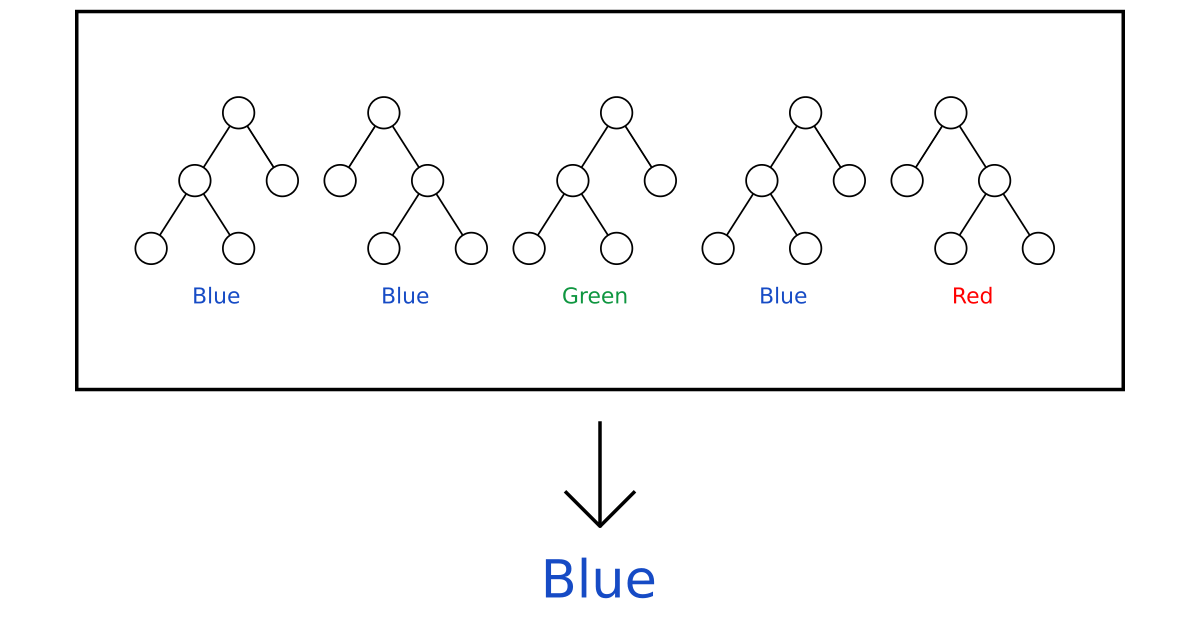

### Train test split

Before we train our model, we have to specify the threshold date in order to split our data on train and test set. First, will will check how many dates we have to predict for our 'test' data set, then we will use this number as the threshold for our train test split.

In [ ]:
print(test.Date.nunique())

So, finally we have 39 weeks to predict, then we will split our data on train and test set, where the last one will be 39 weeks.

In [ ]:
from sklearn.model_selection import train_test_split

threshold_date = pd.to_datetime(tfd_fil.Date.unique()[-test.Date.nunique()]).strftime('%Y-%m-%d')

all_train = tfd_fil[tfd_fil.Date<threshold_date]
all_test = tfd_fil[tfd_fil.Date>=threshold_date]

X_train = all_train.drop(['Date','Weekly_Sales'], axis = 1)
X_test = all_test.drop(['Date','Weekly_Sales'], axis = 1)

y_train = all_train['Weekly_Sales']
y_test = all_test['Weekly_Sales']


#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(X_train)
X_train_sc = mms.transform(X_train)
X_test_sc = mms.transform(X_test)


Train and test data sets are ready to go.  So the train data is the same for both models, while target variable is different. For the second case we will use scaled difference feature.

### Run RF 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import  r2_score

clf = RandomForestRegressor(n_estimators=100, max_samples = 0.4)
clf.fit(X_train_sc, y_train)
clf_pred = clf.predict(X_test_sc)

print('Results with NO differentiation')
print('Weekly_Sales_Mean_test:' ,round(np.mean(y_test) ))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, clf_pred))))
print('R2 Score:', r2_score(y_test, clf_pred))

Now lets plot the results.

In [ ]:
rf_pr = pd.DataFrame({'Weekly_Sales':y_test.values, 'Weekly_Sales_rf_pred': clf_pred}, index = y_test.index)
rf_pred_df = pd.merge(rf_pr, tfd_fil[['Date', 'Store', 'Dept']], left_index = True, right_index = True, how = 'left')

In [ ]:
rf_pred_df.head(2)

In [ ]:
pred_g = rf_pred_df.groupby('Date')['Weekly_Sales','Weekly_Sales_rf_pred'].sum()
act_g = tfd_fil.groupby('Date')['Weekly_Sales'].sum()

ax = act_g[act_g.index>'2011-01-01'].plot(figsize = (20,5), legend = True)
pred_g['Weekly_Sales_rf_pred'].plot(legend = True)


threshold_date = tfd_fil[tfd_fil.Date>'2012-01-01']['Date'].iloc[0].strftime('%Y-%m-%d')
end_date =tfd_fil[tfd_fil.Date>'2012-01-01']['Date'].iloc[-1].strftime('%Y-%m-%d')

plt.title(f'Actual Weekly_Sales VS Predictions\n between {threshold_date} and {end_date}');

As it could be seen from the plot RF model is quite close to reality. 

Lets plot the actual and predicted values for one store of all departments and see models' forecasts. 

In [ ]:
#tfd_fil_pred_start
#tfd_fil
st = 12
s1 = tfd_fil[tfd_fil.Store == st]
fig = plt.figure(figsize = (22,35))
fig.suptitle(f'Walmart Weekly_Sales VS Predictions per {len(s1.Dept.unique())} departments\nfor the {st} store\n(Name is department No) ',y = 0.93,  fontsize = 16)

for dep, num_in_plot in  zip(s1.Dept.unique(), list(range(1,len(s1.Dept.unique())))):
    
    #actual
    act =tfd_fil[(tfd_fil.Store ==st)&(tfd_fil.Dept == dep)]
    act.set_index('Date')
    
    #pred 
    
    pred = rf_pred_df[(rf_pred_df.Store ==st )&(rf_pred_df.Dept == dep)]
    pred.set_index('Date')
    
    ax = fig.add_subplot(19,4,num_in_plot)
    #ax.plot(df_un0[:-len_pred])
    
    ax.plot(act['Weekly_Sales'])
    ax.plot (pred['Weekly_Sales_rf_pred'])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(dep)
    #handles, labels = ax.get_legend_handles_labels()
fig.legend(labels = ('Actual','RF_predicted'), loc=9) #bbox_to_anchor=(1, 0.5))#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

## RNN model

RNN stands for recurrent neural network and is the class of artificial neural network (ANN). The main principal of this network is that it takes the current input, then it returns the output. Afterwards the returned output, becomes an input and then from this input algorithm returns the new output. In comparison with feed forward ANN, Recurrent Neural Network uses its internal memory in order to process the sequence of inputs. That is why the algorithm could be approached with such problems as speech and handwriting recognition and Time Series data as well. 

In [ ]:
print('img source: https://www.youtube.com/watch?v=UNmqTiOnRfg')

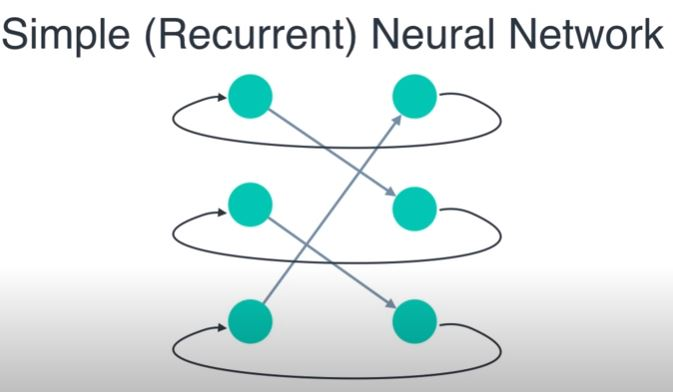

The problem of RNN is concatenated  with the memory space as that is quite short and thus it leads to vanishing gradient problem. And here LSTM comes.
LSTM is the abbreviation for  Long Short Term Memory networks and appears as the modification of RNN. This 'upgrade' allows the networks easier to remember past data, which is quite crucial in our case of problem solving.

At this chapter we will not go too deep into the algorithms' theory as this is a long topic. Instead we will use on our problem solving.

So first, we will create special data frame for our RNN model. Initially, we will create a new feature with the codes, which is simply the combination of store and department number. Then we will transform our df to pivot table, where values are the Sales Volumes, index is Date and columns are codes. Finally, we will fill our NAN values with zeros. 

In [ ]:
df_rnn = tfd_fil[['Date', 'Store', 'Dept', 'Weekly_Sales']]
df_rnn['Date'] = pd.to_datetime(df_rnn['Date'], format = '%Y-%m-%d')
df_rnn['Date'].freq = 'W-FRI'
df_rnn['Store_Dept_code'] = df_rnn.apply(lambda x: str(x['Store']) + '-' + str(x['Dept']), axis = 1)
df_rnn.head(2)

In [ ]:
df_rnn_piv = df_rnn.pivot_table(index = 'Date', columns = 'Store_Dept_code', values = 'Weekly_Sales')
df_rnn_piv =df_rnn_piv.fillna(0)
df_rnn_piv.head(2)

### Train/Test split

The threshold for train and test split will be the same date as we have used for RF.

At the same time, it is a must to scale our data for RNN, what we will perform as well.

In [ ]:
threshold_date = pd.to_datetime(tfd_fil.Date.unique()[-test.Date.nunique()]).strftime('%Y-%m-%d')
#threshold_date = df_rnn[df_rnn.Date>'2012-01-01']['Date'].iloc[0].strftime('%Y-%m-%d')
threshold_date

In [ ]:
train_rnn = df_rnn_piv[df_rnn_piv.index<threshold_date]
test_rnn = df_rnn_piv[df_rnn_piv.index>=threshold_date]

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(train_rnn)
X_train_sc = mms.transform(train_rnn)
X_test_sc = mms.transform(test_rnn)

The next step would be to transform our data frame into the special format required for Recurrent Neural Network and has a few main paramaters to specify:
1. length - this is the amount of input data that we will provide to our model in order to make predictions. For example if we have list of 5 values and these are [1,2,3,4,5] and we specify the length == 3, then algorithm will take three last values from the list ([3,4,5]).  This parameter is mostly specified in correspondence with  seasonal component. As we have seen lastly, we have a year seasonality and our data is weekly. So the formula is 4(weeks in a month) * 12 = 48.
2. batch_size -stands for number of training example used in one iteration. Normally as it was said in studies, lower the batch_size more accurately model fits to the data, however at the same time it spends much more time per 1 epoch. So after several trials I came up with optimal value, which is 10-15.
Tensorflow provides with the function that allows us easily to generate the our data into write format for our model.  

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length  = 48
batch_size = 10 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(X_train_sc, X_train_sc, length=length, batch_size=batch_size)

Now its time to build our model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from keras import layers

# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(64,activation= 'tanh',return_sequences=True, input_shape=(length,X_train_sc.shape[1])))
model.add(LSTM(128, activation='tanh', return_sequences = False))
model.add(Dense(X_train_sc.shape[1])) 

model.compile(optimizer='adam', loss='mse')

Lets also generate the validation set, which our model will use to calculate the loss on each epoch.

In [ ]:
validation_generator = TimeseriesGenerator(X_test_sc,X_test_sc, length=38, batch_size=batch_size)

model.fit(generator,epochs=10,validation_data=validation_generator, verbose=2)

losses = pd.DataFrame(model.history.history)
losses.plot()

This plot shows us the loss for validation and training set.

Now time to make the predictions.

In [ ]:
n_features = X_train_sc.shape[1]
test_predictions = []

first_eval_batch = X_train_sc[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test_rnn)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    clear_output()
    print(len(test_predictions))

In [ ]:
inv_test_pred = mms.inverse_transform(test_predictions)
pred_df = pd.DataFrame (data = inv_test_pred, columns =test_rnn.columns, index = test_rnn.index )

Alright, predictions are ready and before checking the accuracy, lets plot actual Sales vs predicted ones for some random department.

In [ ]:
n = 4
test_rnn.iloc[:,n].plot()
pred_df.iloc[:,n].plot()

In [ ]:
print('No of target features: ', len(df_rnn_piv.columns))

It could be noticed that even though our model's predictions are having the right vector, however the results are quite plain. 
There are two prior methods to solve this problem:
1. add more No of epochs - in this case our model will fit to the training set better and then the results will be less plain as now. However due to the thing that we have totally 3331 features to predict it will take much time.
2. To decrease the number of target features - instead of giving all features to one model at a time, we could split our data into samples and provide just some portion of it. Finally, we could loop this process, until all features are predicted.
In our case we will combine 1st and 2nd method and see the results.  

In [ ]:
import timeit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense,LSTM
from keras import layers

#Main Timer
start_time_main = timeit.default_timer()

#Creating main prediction df
    # identifying the test index once
test_index = df_rnn_piv[df_rnn_piv.index>=threshold_date].index
main_rnn_pred_df = pd.DataFrame(index = test_index)

#threshold date
threshold_date = pd.to_datetime(tfd_fil.Date.unique()[-test.Date.nunique()]).strftime('%Y-%m-%d')
threshold_date

#Sampling
sample_size = 150
whole_range = df_rnn_piv.shape[1]

samp = 0
end = sample_size
start = 0

if (round(whole_range/sample_size)*sample_size)<whole_range:
    extra = 1
else:
    extra = 0
    
samples = round(whole_range/sample_size)+extra
while samp<samples:
    start_time = timeit.default_timer()
    print(f"Working on Sample: [{start}:{end}]")
    #print('start:',start,'end:',end )
 
    # Train Test split
    train_rnn = df_rnn_piv[df_rnn_piv.index<threshold_date].iloc[:,start:end]
    test_rnn = df_rnn_piv[df_rnn_piv.index>=threshold_date].iloc[:,start:end]
    
    # Sampling for next round
    samp = samp+1
    start= start+sample_size
    end = end+sample_size


    # Scaling
    mms = MinMaxScaler()
    mms.fit(train_rnn)
    X_train_sc = mms.transform(train_rnn)
    X_test_sc = mms.transform(test_rnn)
    
    #ML
        #Generating the table
    length  = 48
    batch_size = 20 #Number of timeseries samples in each batch
    generator = TimeseriesGenerator(X_train_sc, X_train_sc, length=length, batch_size=batch_size)
    
        # define model
    model = Sequential()
    model.add(LSTM(128,activation= 'tanh',return_sequences=True, input_shape=(length,X_train_sc.shape[1])))
    model.add(LSTM(64, activation='tanh', return_sequences = False))
    model.add(Dense(X_train_sc.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    
        # Model Training
    validation_generator = TimeseriesGenerator(X_test_sc,X_test_sc, length=38, batch_size=batch_size)
    model.fit(generator,epochs=160,
                        validation_data=validation_generator, verbose=2)#,callbacks=[early_stop])
        
        # Making predictions
    n_features = X_train_sc.shape[1]
    test_predictions = []
    first_eval_batch = X_train_sc[:length]
    current_batch = first_eval_batch.reshape((1, length, n_features))

    for i in range(len(test_rnn)):
    
        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.predict(current_batch)[0]
        # store prediction
        test_predictions.append(current_pred) 
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

        # Creating prediction df
    inv_test_pred = mms.inverse_transform(test_predictions)
    pred_df = pd.DataFrame (data = inv_test_pred, columns =test_rnn.columns, index = test_rnn.index )
    
        # Storing predictions into main prediction df
    main_rnn_pred_df = pd.merge(main_rnn_pred_df,pred_df, right_index=True, left_index=True)
    
    stop_time = timeit.default_timer()
    execution_time = stop_time - start_time
    clear_output()
    print('Samples Done:', samp )
    print('Samples left:', samples- (samp) )
    print("Sample Prediction time is "+str(round(execution_time))+" seconds")

stop_time_main = timeit.default_timer()
execution_time_main = stop_time_main - start_time_main
print ("Forecasting is completed")
print("Whole process took "+str(round(execution_time_main))+" seconds")

In [ ]:
# Store the results
rnn_pred_trans = main_rnn_pred_df.stack().reset_index()
rnn_pred_trans.columns = ['Date', 'Store_Dept_code', 'Weekly_Sales_Rnn']
df_with_pred = pd.merge(df_rnn,rnn_pred_trans, right_on = ['Date', 'Store_Dept_code'], left_on=['Date', 'Store_Dept_code'], how = 'left')

In [ ]:
df_with_pred[~df_with_pred.Weekly_Sales_Rnn.isnull()].Store_Dept_code.nunique()

In [ ]:
# Check for RMSE and R2 scores

from sklearn import metrics
from sklearn.metrics import  r2_score
actual = df_with_pred[~df_with_pred.Weekly_Sales_Rnn.isnull()].Weekly_Sales
predicted = df_with_pred[~df_with_pred.Weekly_Sales_Rnn.isnull()].Weekly_Sales_Rnn


print('Results of RNN Model')
print('Weekly_Sales_Mean_test:' ,round(np.mean(actual) ))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(actual, predicted))))
print('R2 Score:', r2_score(actual, predicted))

Overall the results of RNN is a bit worse then RF model, but before making the conclusion lets plot the predictions for one random store and its departments.

In [ ]:
#tfd_fil_pred_start
#tfd_fil
st = 12
s1 = tfd_fil[tfd_fil.Store == st]
fig = plt.figure(figsize = (22,35))
fig.suptitle(f'Walmart Weekly_Sales VS Predictions per {len(s1.Dept.unique())} departments\nfor the {st} store\n(Name is department No) ',y = 0.93,  fontsize = 16)

for dep, num_in_plot in  zip(s1.Dept.unique(), list(range(1,len(s1.Dept.unique())))):
    
    #actual
    df_temp = df_with_pred[~df_with_pred.Weekly_Sales_Rnn.isnull()]
    df_temp =df_temp[(df_temp.Store ==st)&(df_temp.Dept == dep)]
    df_temp.set_index('Date', inplace = True)
    
    ax = fig.add_subplot(19,4,num_in_plot)
    
    ax.plot(df_temp['Weekly_Sales'])
    ax.plot(df_temp['Weekly_Sales_Rnn'])

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(dep)
fig.legend(labels = ('Actual','Predicted_RNN'), loc=9) #bbox_to_anchor=(1, 0.5))#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

To conclude, Random Forest model made a better job comapre to Recurrent Neural Networks and secondly it was much faster. Thus RF model is the winner in this competition.